In [3199]:
import sys
import torch
import importlib
import numpy as np
import scipy
import matplotlib.pyplot as plt
from torch.autograd import grad  
import utils_PDE  # Ensure you import the module itself, not specific items
importlib.reload(utils_PDE)  # Reload the module to apply updates
from utils_PDE import *

In [3200]:
def analytic_solution(x_bv, x_loc):
    
    a, x0 = x_bv[:,None,0], x_bv[:,None,1] 
    x, t = x_loc[None,:,0], x_loc[None,:,1] 
    sol = torch.tensor( 3*a**2 / np.cosh((a*(((x + x0) + 1 - a**2*t) % 2 - 1))/2)**2).unsqueeze(-1)
    
    return sol

def get_data(num_bv, num_loc):
    c = np.random.uniform(low=0, high=1, size=(num_bv, 1)).astype(np.float32)
    a = np.random.uniform(low=-1, high=1, size=(num_bv, 1)).astype(np.float32)
    x_bv = np.concatenate((c,a), axis=1)

    t = np.random.uniform(low=0, high=1, size=(num_loc, 1)).astype(np.float32)
    x = np.random.uniform(low=-1, high=1, size=(num_loc, 1)).astype(np.float32)
    x_loc = np.concatenate((x,t), axis=1)

    return analytic_solution(x_bv, x_loc), (x_bv, x_loc)

In [3201]:
# 10 x 10 training points
y_train, X_train = get_data(100, 100)

# 10 x 10 training points
y_test, X_test = get_data(10, 10)


In [3202]:
N = 100

model = Model(N=N, K=5, num_iv=50, num_t=50, layer_sizes_branch=[40, 40, 40, 40], layer_sizes_trunk=[40, 40, 40, 40], conserve=True)

model.train(30_000)

#for param in model.weight.parameters():
#    param.requires_grad = False

Step 	 Train loss 	 Test loss


KeyboardInterrupt: 

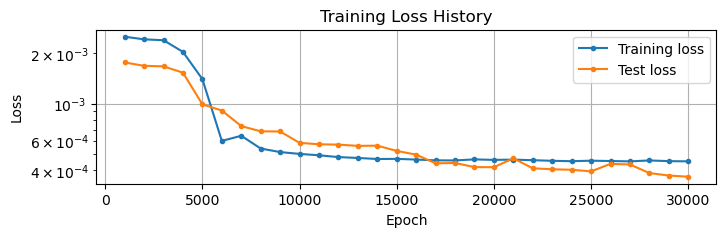

In [3079]:
model.plot_losshistory()

In [3203]:

def plot_conservation(a, x0, N, dpi=100):
        
        d = torch.concatenate((torch.tensor([1]), np.sqrt(2)*torch.ones(model.N)))
        
        f = lambda x, a, t, x0: 3 * a**2 / np.cosh((a * (((x + x0) + 1 - a**2 * t) % 2 - 1)) / 2)**2
        integrate = lambda coeffs: 2*(torch.linalg.norm(d * coeffs, axis=1)**2)
                    
        # Energy test boundary values
        analytical_integral =  model.I(a) 
        
        t = torch.linspace(0, 1, 100, dtype=torch.float32)[:,None]        
        iv =  torch.tensor([[a, x0]], dtype=torch.float32)
        t_ = np.linspace(0, 1, 100, dtype=np.float32)[:,None]  
        
        t_np = np.asarray(t, dtype=np.float32)
        x = np.linspace(-1, 1, 2*model.N+1)[None, :]
        
        analytical_sol = f(x, a, x0, t_np)
        analytical_coeffs = np.fft.rfft(analytical_sol) / (2*model.N+1) 
        
        
 
        # Calculate total energy
        pred = model.net(iv, t)[0,...]  
        pred_coeffs = np.fft.rfft(pred.detach()) / (2*model.N+1) 
        
        pred_integral = scipy.integrate.simpson(pred.detach(), x=np.linspace(-1, 1, 2*model.N+1), axis=1)
        
        pred_coeff_norm = integrate(pred_coeffs)
        analytic_coeff_norm = integrate(analytical_coeffs)
        
        t = t.detach()
        
        _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
        
        ax.set_title('$\int_{\mathbb{T}} u^2(x,t)dx$ over time for $(a, x_0)$=' + f'({a}, {x0})')
        ax.plot(t, torch.ones_like(t)*analytical_integral, alpha=0.5, linewidth=5, label='True')
        ax.plot(t, pred_integral, '--', alpha=0.8, linewidth=3,  label='Pred Integral (via Simpson)')
        ax.plot(t, pred_coeff_norm, '--', alpha=0.8, linewidth=3,  label='Pred Coeff. Norm')
        ax.plot(t, analytic_coeff_norm, '--', alpha=0.8, linewidth=3,  label='Analytic Truncated Coeff. Norm')
        ax.legend()
        ax.grid(True)
        
        ax.set_xlabel("t")
        ax.set_ylabel("$\int_{\mathbb{T}} u^2(x, t)dx$")
        plt.show()

/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_47698/1071451173.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  integrate = lambda coeffs: 2*(torch.linalg.norm(d * coeffs, axis=1)**2)


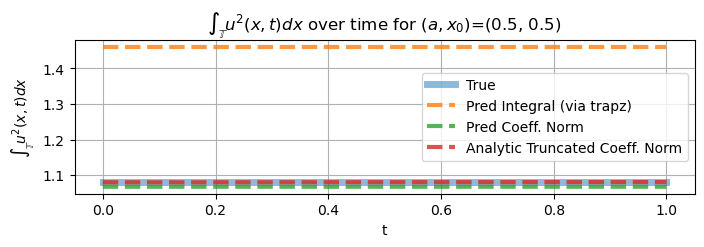

In [3204]:
plot_conservation(a=0.5, x0=0.5, N=10)

In [3042]:
def plot_predictions(a, x0, T): 
    
    d = torch.concatenate((torch.tensor([1]), np.sqrt(2)*torch.ones(model.N)))
    integrate = lambda coeffs, d=d : 2*(torch.linalg.norm(d * coeffs, axis=2)**2)

    
    a = np.array(a).astype(np.float32)
    x0 = np.array(x0).astype(np.float32)
    t = np.array([T]).astype(np.float32)

    
    def analytical_solution(self, a, x0, t):
        x = np.linspace(-1, 1, 2*model.N+1)[None, None, :]
        a, x0, t = a[:, None, None], x0[:, None, None], t[None, :, None]
        return model.f(x, a, t, x0), x[0,0,:]
    
    
    ground_truth, x = analytical_solution(a, x0, t)
    pred = model.predict(a, x0, t)
    
    
    # Plot prediction vs. solution
    fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

    ax.set_title(f'Prediction of KdV Solution Using a DeepONet (for $t=${T})')
    O, o = x[0], ground_truth[0,0,0]
    
    

    #ax.plot(x, ground_truth[l,0,:][0:], label=label, alpha=0.3, linewidth=5, c=f'C{l}')
    ax.plot(O, o, c='k', alpha=0.3, linewidth=5, label='Actual solution')
    ax.plot(O, o, '--', c='grey', label='Predicted solution')

    for l in range(ground_truth.shape[0]):
        label = '({:.1f}, {:.1f})'.format(a[l], x0[l])
        
        ax.plot(x, ground_truth[l,0,:][0:], label=label, alpha=0.5, linewidth=5, c=f'C{l}')
        ax.plot(x, pred[l,0,:].tolist()[0:], '--', c=f'C{l}')

        ax.legend()
        ax.grid(True)
    ax.set_ylabel(f"u(x,{T})")
    ax.set_xlabel("x")
    plt.show()

/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_47698/3906155821.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  coeffs = coeffs*np.sqrt(analytic_integral[...,None] / truncated_integral[...,None])


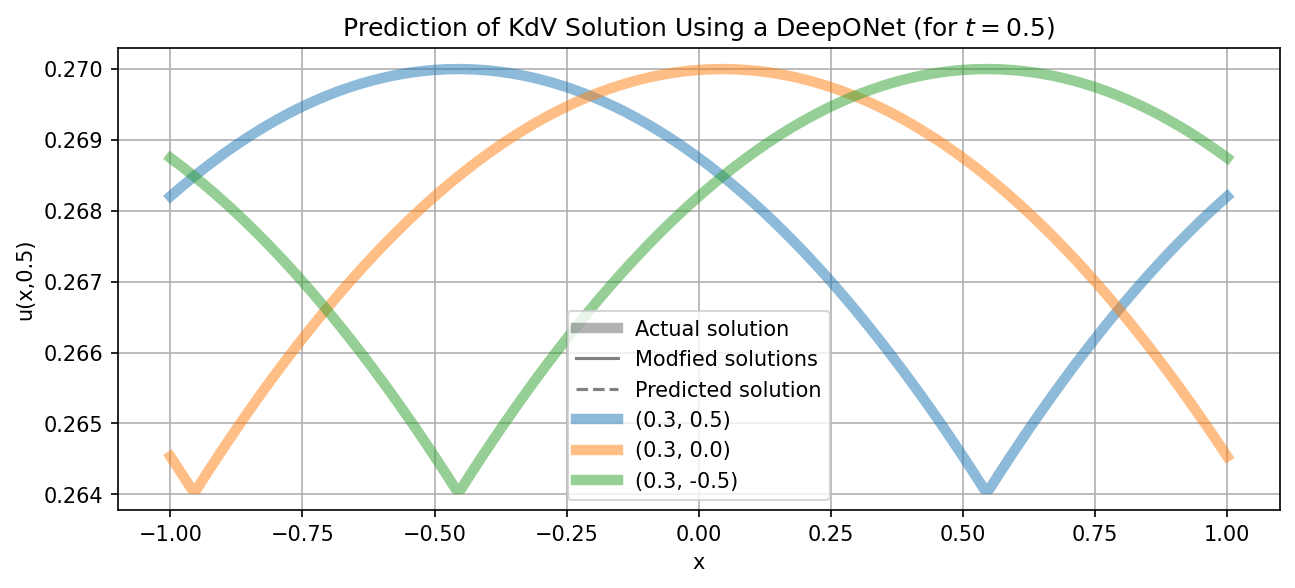

In [3056]:
plot_predictions(a=[0.3, 0.3, 0.3], x0=[0.5, 0, -0.5], T=0.5)

In [2934]:
print(model.net.p)

Parameter containing:
tensor([1.0017], requires_grad=True)
